In [0]:
#THE DATA WAS UPLOADED TO FILESTORE TABLES USING THE DATA IMPORT TAB
#TO MAKE IT RERUNNABLE A VARIABLE WAS DECLARED TO HOLD THE FILE
filetrack = 'clinicaltrial_2021'

In [0]:
#COPYING THE FILE FROM DFBS TO A TEMPORAL FOLDER DIRECTORY TO ENABLE UNZIPPING
#dbutils toolkit doesn't provide an unzip command,the file was copied to the driver node
dbutils.fs.cp("/FileStore/tables/" + filetrack + '.zip', "file:/tmp/")

Out[2]: True

In [0]:
%sh
ls /tmp/

Rserv
RtmpMuluiR
chauffeur-daemon-params
chauffeur-daemon.pid
chauffeur-env.sh
clinicaltrial_2021.zip
custom-spark.conf
driver-daemon-params
driver-daemon.pid
driver-env.sh
hsperfdata_root
systemd-private-3fb9da1b077044d18a40b2b027a88e50-apache2.service-0TJRwf
systemd-private-3fb9da1b077044d18a40b2b027a88e50-ntp.service-XQzJzh
systemd-private-3fb9da1b077044d18a40b2b027a88e50-systemd-logind.service-lfW7Ue
systemd-private-3fb9da1b077044d18a40b2b027a88e50-systemd-resolved.service-vqDDyf
tmp.16odpNvmHe


In [0]:
# Local filesystem/shell command line doesn’t know the “filetrack” variable OS was imported to make it accessible using the command line.
import os
os.environ['filetrack'] = filetrack

Using the UNIX command unzip to extract the contents

In [0]:

%sh
unzip -d /tmp/ /tmp/$filetrack

Archive:  /tmp/clinicaltrial_2021.zip
  inflating: /tmp/clinicaltrial_2021.csv  


In [0]:
#dbutils.fs.rm("FileStore/tables/" + filetrack, True)

In [0]:
#MOVING THE UNZIPPED FILE FROM DRIVER NODE/TMP TO THE  DBFS FILESTORE
dbutils.fs.mv("file:/tmp/" + filetrack + '.csv', "/FileStore/tables/", True)

Out[7]: True

In [0]:
#VIEWING THE FOLDER AFTER MOVING THE FILE
dbutils.fs.ls("FileStore/tables/"+ filetrack + '.csv')

Out[8]: [FileInfo(path='dbfs:/FileStore/tables/clinicaltrial_2021.csv', name='clinicaltrial_2021.csv', size=50359696, modificationTime=1681121988000)]

In [0]:
#DATASET/FILE EXPLORATION TO HAVE AN INSIGHT ON THE STRUCTURE AND SCHEMA
dbutils.fs.head("FileStore/tables/" +  filetrack + '.csv')

[Truncated to first 65536 bytes]
Out[9]: "Id|Sponsor|Status|Start|Completion|Type|Submission|Conditions|Interventions\r\nNCT02758028|The University of Hong Kong|Recruiting|Aug 2005|Nov 2021|Interventional|Apr 2016||\r\nNCT02751957|Duke University|Completed|Jul 2016|Jul 2020|Interventional|Apr 2016|Autistic Disorder,Autism Spectrum Disorder|\r\nNCT02758483|Universidade Federal do Rio de Janeiro|Completed|Mar 2017|Jan 2018|Interventional|Apr 2016|Diabetes Mellitus|\r\nNCT02759848|Istanbul Medeniyet University|Completed|Jan 2012|Dec 2014|Observational|May 2016|Tuberculosis,Lung Diseases,Pulmonary Disease|\r\nNCT02758860|University of Roma La Sapienza|Active, not recruiting|Jun 2016|Sep 2020|Observational [Patient Registry]|Apr 2016|Diverticular Diseases,Diverticulum,Diverticulosis|\r\nNCT02757209|Consorzio Futuro in Ricerca|Completed|Apr 2016|Jan 2018|Interventional|Apr 2016|Asthma|Fluticasone,Xhance,Budesonide,Formoterol Fumarate,Salmeterol Xinafoate\r\nNCT02752438|Ankara University|Unkn

In [0]:
#PRESENTING THE DATASET IN A MORE PRESENTABLE FORM USING SPLITLINES FUNCTION
for line in dbutils.fs.head("FileStore/tables/" +  filetrack + '.csv').splitlines():
    print(line)


[Truncated to first 65536 bytes]
Id|Sponsor|Status|Start|Completion|Type|Submission|Conditions|Interventions
NCT02758028|The University of Hong Kong|Recruiting|Aug 2005|Nov 2021|Interventional|Apr 2016||
NCT02751957|Duke University|Completed|Jul 2016|Jul 2020|Interventional|Apr 2016|Autistic Disorder,Autism Spectrum Disorder|
NCT02758483|Universidade Federal do Rio de Janeiro|Completed|Mar 2017|Jan 2018|Interventional|Apr 2016|Diabetes Mellitus|
NCT02759848|Istanbul Medeniyet University|Completed|Jan 2012|Dec 2014|Observational|May 2016|Tuberculosis,Lung Diseases,Pulmonary Disease|
NCT02758860|University of Roma La Sapienza|Active, not recruiting|Jun 2016|Sep 2020|Observational [Patient Registry]|Apr 2016|Diverticular Diseases,Diverticulum,Diverticulosis|
NCT02757209|Consorzio Futuro in Ricerca|Completed|Apr 2016|Jan 2018|Interventional|Apr 2016|Asthma|Fluticasone,Xhance,Budesonide,Formoterol Fumarate,Salmeterol Xinafoate
NCT02752438|Ankara University|Unknown status|May 2016|Jul 2017|O

#NUMBER OF STUDIES : QUESTION ONE PROCEDURE AND ANSWER

In [0]:
#CONVERTING TO A DATAFRAME
from pyspark.sql.types import *

myRDD = sc.textFile("/FileStore/tables/" + filetrack + '.csv') \
           .map(lambda line: line.split("|")) \
           .filter(lambda row: row[0] != "Id")  # filter out the header row
           
myDF1 = spark.createDataFrame(myRDD, schema=StructType([
    StructField("Id", StringType()),
    StructField("Sponsor", StringType()),
    StructField("Status", StringType()),
    StructField("Start", StringType()),
    StructField("Completion", StringType()),
    StructField("Type", StringType()),
    StructField("Submissions", StringType()),
    StructField("Conditions", StringType()),
    StructField("Interventions", StringType())
]))
myDF1.show(5, truncate=False)
myDF1.printSchema()


+-----------+--------------------------------------+----------------------+--------+----------+--------------------------------+-----------+-------------------------------------------------+-------------+
|Id         |Sponsor                               |Status                |Start   |Completion|Type                            |Submissions|Conditions                                       |Interventions|
+-----------+--------------------------------------+----------------------+--------+----------+--------------------------------+-----------+-------------------------------------------------+-------------+
|NCT02758028|The University of Hong Kong           |Recruiting            |Aug 2005|Nov 2021  |Interventional                  |Apr 2016   |                                                 |             |
|NCT02751957|Duke University                       |Completed             |Jul 2016|Jul 2020  |Interventional                  |Apr 2016   |Autistic Disorder,Autism Spectrum Disord

In [0]:
#CONVERTING TO PANDAS FOR A BETTER VIEW
Neat_View = myDF1.toPandas()
Neat_View

,Id,Sponsor,Status,Start,Completion,Type,Submissions,Conditions,Interventions
0,NCT02758028,The University of Hong Kong,Recruiting,Aug 2005,Nov 2021,Interventional,Apr 2016,,
1,NCT02751957,Duke University,Completed,Jul 2016,Jul 2020,Interventional,Apr 2016,"Autistic Disorder,Autism Spectrum Disorder",
2,NCT02758483,Universidade Federal do Rio de Janeiro,Completed,Mar 2017,Jan 2018,Interventional,Apr 2016,Diabetes Mellitus,
3,NCT02759848,Istanbul Medeniyet University,Completed,Jan 2012,Dec 2014,Observational,May 2016,"Tuberculosis,Lung Diseases,Pulmonary Disease",
4,NCT02758860,University of Roma La Sapienza,"Active, not recruiting",Jun 2016,Sep 2020,Observational [Patient Registry],Apr 2016,"Diverticular Diseases,Diverticulum,Diverticulosis",
...,...,...,...,...,...,...,...,...,...
387256,NCT04576611,University of the Balearic Islands,Completed,Mar 2019,Feb 2020,Interventional,Jul 2020,"Back Pain,Low Back Pain",
387257,NCT04571138,Seattle Children's Hospital,Recruiting,Sep 2020,Feb 2038,Interventional,Sep 2020,"Lymphoma,Leukemia",
387258,NCT04578847,"National Research Center for Hematology, Russia","Active, not recruiting",Jan 2020,Jan 2025,Interventional,Mar 2020,Leukemia,"Imatinib Mesylate,Dasatinib"
387259,NCT04577300,Stanford University,Recruiting,May 2021,Dec 2023,Interventional,Sep 2020,Glaucoma,


In [0]:
#THE COUNT OF STUDIES
Study_Count = myDF1.count()
print("Number of Studies for the year:", Study_Count)


Number of Studies for the year: 387261


#TYPES OF STUDIES AND FREQUENCY:  Q2 ANSWER

In [0]:
#TYPES OF STUDIES AND THEIR FREQUENCIES
from pyspark.sql.functions import count
#applying the count function on the Type column, getting the aggregate and frequency of each study for the year in a descending order
myDF2 = myDF1.select("Type").groupBy("Type").agg(count("*").alias("frequency")).orderBy("frequency", ascending=False) 
myDF2.show()


+--------------------+---------+
|                Type|frequency|
+--------------------+---------+
|      Interventional|   301472|
|       Observational|    77540|
|Observational [Pa...|     8180|
|     Expanded Access|       69|
+--------------------+---------+



In [0]:
#PLOTTING THE VALUES USING SEABORN
TypeDF = myDF2.toPandas()

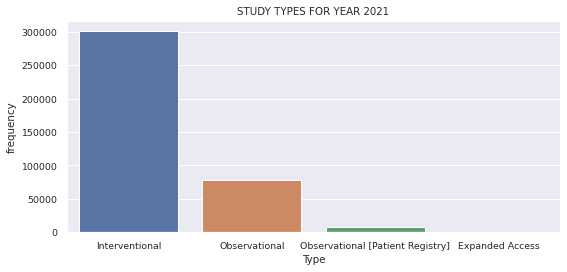

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")
plt.figure(figsize=(7, 3))
sns.barplot(x="Type", y="frequency", data=TypeDF)

# set title and labels
plt.title("STUDY TYPES FOR YEAR 2021")
plt.xlabel("Type")
plt.ylabel("frequency")

# show the plot
plt.show()


#TOP 5 CONDITIONS: QUESTION THREE PROCEDURE AND ANSWER

In [0]:
#TOP 5 CONDITIONS FROM THE DATASET
#applying the count function on the conditions column, getting the aggregate and frequency of each study for the year limiting to top 5
myDF3 = myDF1.select("Conditions") \
    .groupBy("Conditions") \
    .agg(count("*").alias("Frequency")) \
    .orderBy("Frequency", ascending=False) \
    .limit(5) 

myDF3.show()


+-------------------+---------+
|         Conditions|Frequency|
+-------------------+---------+
|                   |    65131|
|  Diabetes Mellitus|     7460|
|   Breast Neoplasms|     6054|
|          Carcinoma|     3788|
|Prostatic Neoplasms|     3700|
+-------------------+---------+



This code below filters out empty rows from the Conditions column, splits the remaining rows by comma-separated values using split(), explodes the resulting array using explode(), groups the data by Condition and counts the frequency of each group using agg(). Finally, it sorts the results in descending order by frequency and limits the output to the top 5.

In [0]:
#Here the column was filetered further to remove the empty rows and further split the rows at comma separated values then aggregates the frequency

from pyspark.sql.functions import count, split, explode

myDF4 = myDF1.filter(myDF1.Conditions != '').select('Conditions') \
     .withColumn('Conditions', explode(split('Conditions', '\s*,\s*'))) \
     .groupBy('Conditions') \
     .agg(count('*').alias('Frequency')) \
     .orderBy('Frequency', ascending=False) \
     .limit(5) 
myDF4.show()


+-----------------+---------+
|       Conditions|Frequency|
+-----------------+---------+
|        Carcinoma|    13389|
|Diabetes Mellitus|    11080|
|        Neoplasms|     9371|
| Breast Neoplasms|     8640|
|         Syndrome|     8032|
+-----------------+---------+



In [0]:
#PLOTTING THE VALUES USING SEABORN
CondDF = myDF4.toPandas()

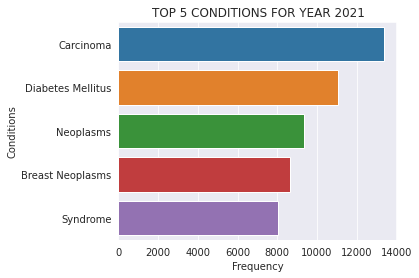

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")
plt.figure(figsize=(5, 4))
sns.barplot(x="Frequency", y="Conditions", data=CondDF.head(5))

# set title and labels
plt.title("TOP 5 CONDITIONS FOR YEAR 2021")
plt.xlabel("Frequency")
plt.ylabel("Conditions")

# show the plot
plt.show()


#TOP 10 COMMON SPONSORS: QUESTION FOUR PROCEDURE AND ANSWER

In [0]:
#TO MAKE IT RERUNNABLE A VARIABLE WAS DECLARED TO HOLD THE FILE
filetrack1 = 'pharma'

In [0]:
#COPYING THE FILE FROM DFBS TO A TEMPORAL FOLDER DIRECTORY TO ENABLE UNZIPPING
#dbutils toolkit doesn't provide an unzip command,the file was copied to the driver node
dbutils.fs.cp("/FileStore/tables/" + filetrack1 + '.zip', "file:/tmp/")

Out[22]: True

In [0]:
#ENSURING THE FILE IS IN THE TMP DIRECTORY

In [0]:
%sh
ls /tmp/

Rserv
RtmpMuluiR
chauffeur-daemon-params
chauffeur-daemon.pid
chauffeur-env.sh
clinicaltrial_2021.zip
custom-spark.conf
driver-daemon-params
driver-daemon.pid
driver-env.sh
hsperfdata_root
pharma.zip
systemd-private-3fb9da1b077044d18a40b2b027a88e50-apache2.service-0TJRwf
systemd-private-3fb9da1b077044d18a40b2b027a88e50-ntp.service-XQzJzh
systemd-private-3fb9da1b077044d18a40b2b027a88e50-systemd-logind.service-lfW7Ue
systemd-private-3fb9da1b077044d18a40b2b027a88e50-systemd-resolved.service-vqDDyf
tmp.16odpNvmHe


In [0]:
#USING UNIX COMMAND TO UNZIP

In [0]:
# Local filesystem/shell command line doesn’t know the “filetrack” variable OS was imported to make it accessible using the command line.
import os
os.environ['filetrack1'] = filetrack1

In [0]:
%sh
unzip -d /tmp/ /tmp/$filetrack1

Archive:  /tmp/pharma.zip
  inflating: /tmp/pharma.csv         


In [0]:
#MOVING THE UNZIPPED FILE FROM DRIVER NODE/TMP TO THE  DBFS FILESTORE
dbutils.fs.mv("file:/tmp/" + filetrack1 + '.csv', "/FileStore/tables/", True)

Out[28]: True

In [0]:
#VIEWING THE FOLDER AFTER MOVING THE FILE
dbutils.fs.ls("FileStore/tables/"+ filetrack1 + '.csv')

Out[29]: [FileInfo(path='dbfs:/FileStore/tables/pharma.csv', name='pharma.csv', size=678999, modificationTime=1681122074000)]

In [0]:
#DATASET/FILE EXPLORATION TO HAVE AN INSIGHT ON THE STRUCTURE AND SCHEMA
dbutils.fs.head("FileStore/tables/" +  filetrack1 + '.csv')

[Truncated to first 65536 bytes]
Out[30]: '"Company","Parent_Company","Penalty_Amount","Subtraction_From_Penalty","Penalty_Amount_Adjusted_For_Eliminating_Multiple_Counting","Penalty_Year","Penalty_Date","Offense_Group","Primary_Offense","Secondary_Offense","Description","Level_of_Government","Action_Type","Agency","Civil/Criminal","Prosecution_Agreement","Court","Case_ID","Private_Litigation_Case_Title","Lawsuit_Resolution","Facility_State","City","Address","Zip","NAICS_Code","NAICS_Translation","HQ_Country_of_Parent","HQ_State_of_Parent","Ownership_Structure","Parent_Company_Stock_Ticker","Major_Industry_of_Parent","Specific_Industry_of_Parent","Info_Source","Notes"\n"Abbott Laboratories","Abbott Laboratories","$5,475,000","$0","$5,475,000","2013","20131227","government-contracting-related offenses","False Claims Act and related","kickbacks and bribery","Abbott Laboratories agreed to $5.475 million to resolve allegations that it violated the False Claims Act by paying kickbacks to in

In [0]:
#PRESENTING THE DATASET IN A MORE PRESENTABLE FORM USING SPLITLINES FUNCTION
for line in dbutils.fs.head("FileStore/tables/" +  filetrack1 + '.csv').splitlines():
    print(line)


[Truncated to first 65536 bytes]
"Company","Parent_Company","Penalty_Amount","Subtraction_From_Penalty","Penalty_Amount_Adjusted_For_Eliminating_Multiple_Counting","Penalty_Year","Penalty_Date","Offense_Group","Primary_Offense","Secondary_Offense","Description","Level_of_Government","Action_Type","Agency","Civil/Criminal","Prosecution_Agreement","Court","Case_ID","Private_Litigation_Case_Title","Lawsuit_Resolution","Facility_State","City","Address","Zip","NAICS_Code","NAICS_Translation","HQ_Country_of_Parent","HQ_State_of_Parent","Ownership_Structure","Parent_Company_Stock_Ticker","Major_Industry_of_Parent","Specific_Industry_of_Parent","Info_Source","Notes"
"Abbott Laboratories","Abbott Laboratories","$5,475,000","$0","$5,475,000","2013","20131227","government-contracting-related offenses","False Claims Act and related","kickbacks and bribery","Abbott Laboratories agreed to $5.475 million to resolve allegations that it violated the False Claims Act by paying kickbacks to induce doctor

In [0]:
#reading the pharma file into a dataframe
pharmDF = spark.read.options(delimiter=",").csv("/FileStore/tables/" + filetrack1 + '.csv', header =True)
pharmDF.show(5,truncate = False)


+-------------------------------------+-------------------+--------------+------------------------+---------------------------------------------------------+------------+------------+---------------------------------------+-----------------------------------------------------+------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------+-------------+-------------------

In [0]:
pharmDF.printSchema()

root
 |-- Company: string (nullable = true)
 |-- Parent_Company: string (nullable = true)
 |-- Penalty_Amount: string (nullable = true)
 |-- Subtraction_From_Penalty: string (nullable = true)
 |-- Penalty_Amount_Adjusted_For_Eliminating_Multiple_Counting: string (nullable = true)
 |-- Penalty_Year: string (nullable = true)
 |-- Penalty_Date: string (nullable = true)
 |-- Offense_Group: string (nullable = true)
 |-- Primary_Offense: string (nullable = true)
 |-- Secondary_Offense: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Level_of_Government: string (nullable = true)
 |-- Action_Type: string (nullable = true)
 |-- Agency: string (nullable = true)
 |-- Civil/Criminal: string (nullable = true)
 |-- Prosecution_Agreement: string (nullable = true)
 |-- Court: string (nullable = true)
 |-- Case_ID: string (nullable = true)
 |-- Private_Litigation_Case_Title: string (nullable = true)
 |-- Lawsuit_Resolution: string (nullable = true)
 |-- Facility_State: string (

pharmDF1 = pharmDF.toDF('Company', 'Parent_Company','Penalty_Amount', 'Subtraction_From_Penalty', 'Penalty_Amount_Adjusted_For_Eliminating_Multiple_Counting', 'Penalty_Year', 'Penalty_Date', 'Offense_Group', 'Primary_Offense', 'Secondary_Offense', 'Description', 'Level_of_Government', 'Action_Type', 'Agency', 'Civil/Criminal', 'Prosecution_Agreement', 'Court', 'Case_ID', 'Private_Litigation_Case_Title', 'Lawsuit_Resolution', 'Facility_State', 'City', 'Address', 'Zip', 'NAICS_Code', 'NAICS_Translation', 'HQ_Country_of_Parent', 'HQ_State_of_Parent', 'Ownership_Structure', 'Parent_Company_Stock_Ticker', 'Major_Industry_of_Parent', 'Specific_Industry_of_Parent', 'Info_Source', 'Notes')

pharmDF1.show(10, truncate = False)

In [0]:
#NEAT FORMAT
Neat_View1 = pharmDF.toPandas()
Neat_View1

,Company,Parent_Company,Penalty_Amount,Subtraction_From_Penalty,Penalty_Amount_Adjusted_For_Eliminating_Multiple_Counting,Penalty_Year,Penalty_Date,Offense_Group,Primary_Offense,Secondary_Offense,...,NAICS_Code,NAICS_Translation,HQ_Country_of_Parent,HQ_State_of_Parent,Ownership_Structure,Parent_Company_Stock_Ticker,Major_Industry_of_Parent,Specific_Industry_of_Parent,Info_Source,Notes
0,Abbott Laboratories,Abbott Laboratories,"$5,475,000",$0,"$5,475,000",2013,20131227,government-contracting-related offenses,False Claims Act and related,kickbacks and bribery,...,None,None,USA,Illinois,publicly traded,ABT,pharmaceuticals,pharmaceuticals,https://www.justice.gov/opa/pr/abbott-laborato...,None
1,Abbott Laboratories Inc.,AbbVie,"$1,500,000,000",$0,"$1,500,000,000",2012,20120507,healthcare-related offenses,off-label or unapproved promotion of medical p...,None,...,None,None,USA,Illinois,publicly traded,ABBV,pharmaceuticals,pharmaceuticals,http://www.justice.gov/opa/pr/abbott-labs-pay-...,None
2,Abbott Laboratories Inc.,AbbVie,"$126,500,000",$0,"$126,500,000",2010,20101207,government-contracting-related offenses,False Claims Act and related,None,...,None,None,USA,Illinois,publicly traded,ABBV,pharmaceuticals,pharmaceuticals,https://www.justice.gov/opa/pr/pharmaceutical-...,None
3,"Abbott Laboratories Puerto Rico, Inc.",Abbott Laboratories,"$49,045",$0,"$49,045",2009,20090305,employment-related offenses,wage and hour violation,Fair Labor Standards Act,...,423450,"423450: Medical, Dental, and Hospital Equipmen...",USA,Illinois,publicly traded,ABT,pharmaceuticals,pharmaceuticals,"March 7, 2017 download of a dataset posted by ...",Date and year are the Findings End Date in the...
4,Acclarent Inc.,Johnson & Johnson,"$18,000,000",$0,"$18,000,000",2016,20160722,government-contracting-related offenses,False Claims Act and related,None,...,None,None,USA,New Jersey,publicly traded,JNJ,pharmaceuticals,pharmaceuticals,https://www.justice.gov/opa/pr/johnson-johnson...,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
963,Purdue Pharma,Purdue Pharma,"$10,000,000,000",$0,"$10,000,000,000",2021,20210901,healthcare-related offenses,off-label or unapproved promotion of medical p...,None,...,None,None,USA,Connecticut,out of business,None,pharmaceuticals,pharmaceuticals,https://www.washingtonpost.com/business/2021/0...,None
964,Bristol Myers Squibb Co.,Bristol-Myers Squibb,"$75,000,000",$0,"$75,000,000",2021,20210817,government-contracting-related offenses,False Claims Act and related,None,...,None,None,USA,New York,publicly traded,BMY,pharmaceuticals,pharmaceuticals,https://portal.ct.gov/AG/Press-Releases/2021-P...,None
965,Johnson & Johnson,Johnson & Johnson,"$5,000,000,000",$0,"$5,000,000,000",2021,20210721,healthcare-related offenses,off-label or unapproved promotion of medical p...,None,...,None,None,USA,New Jersey,publicly traded,JNJ,pharmaceuticals,pharmaceuticals,https://ncdoj.gov/attorney-general-josh-stein-...,None
966,Endo Health Solutions,Endo International,"$50,000,000",$0,"$50,000,000",2021,20210910,healthcare-related offenses,off-label or unapproved promotion of medical p...,None,...,None,None,Ireland,None,publicly traded,ENDP,pharmaceuticals,pharmaceuticals,https://ag.ny.gov/press-release/2021/attorney-...,None


In [0]:
type(pharmDF)

Out[35]: pyspark.sql.dataframe.DataFrame

In [0]:
#CLEANING OF THE PHARMA TO GET THE FREQUENCY OF VALUES IN THE PARENT COMPANY COLUMN FOR ONWARD ANALYSIS
from pyspark.sql.functions import count, split, explode, col

# Define the delimiter
delimiter = '|'

# Load the data from the file

# Define the columns to keep
keep_columns = ['Company', 'Parent_Company', 'Penalty_Amount', 'Subtraction_From_Penalty',
                'Penalty_Amount_Adjusted_For_Eliminating_Multiple_Counting', 'Penalty_Year',
                'Penalty_Date', 'Offense_Group', 'Primary_Offense', 'Secondary_Offense',
                'Description', 'Level_of_Government', 'Action_Type', 'Agency', 'Civil/Criminal',
                'Prosecution_Agreement', 'Court', 'Case_ID', 'Private_Litigation_Case_Title',
                'Lawsuit_Resolution', 'Facility_State', 'City', 'Address', 'Zip', 'NAICS_Code',
                'NAICS_Translation', 'HQ_Country_of_Parent', 'HQ_State_of_Parent',
                'Ownership_Structure', 'Parent_Company_Stock_Ticker', 'Major_Industry_of_Parent',
                'Specific_Industry_of_Parent', 'Info_Source', 'Notes']

# Filter out rows where the first value in the Parent_Company column is not in keep_values
keep_values = set(keep_columns)
pharmDF1 = pharmDF.filter(col('Parent_Company').rlike(f'^({"|".join(keep_values)}){delimiter}'))

# Split Parent_Company by '|' and explode the resulting array
pharmDF2 = pharmDF1.withColumn('Parent_Company', explode(split('Parent_Company', '\n')))

# Convert to RDD and perform operations
pharmRDD = pharmDF2.rdd
phm_myrdd1 = pharmRDD.map(lambda row: row[0] + "," + row[1])
phm_myrdd2 = phm_myrdd1.map(lambda s: s.replace('"','')).map(lambda s:s.split(',')[1])
phm_myrdd3 = phm_myrdd2.filter(lambda x: x.split(",")[0] > '0')
phm_myrdd4 = phm_myrdd3.map(lambda x:(x.split(",")[0],1))
reduced_phm_myrdd4 = phm_myrdd4.reduceByKey(lambda a,b: a + b)
phm_myrdd5 = reduced_phm_myrdd4.sortBy(lambda x: x[1], False)

# Convert back to DataFrame and display results
pharmDF3 = spark.createDataFrame(phm_myrdd5, ['Parent_Company', 'Frequency']).limit(10)
pharmDF3.show(truncate=False)


+------------------------------+---------+
|Parent_Company                |Frequency|
+------------------------------+---------+
|Merck                         |64       |
|Pfizer                        |52       |
|Johnson & Johnson             |39       |
|AbbVie                        |38       |
|Bristol-Myers Squibb          |36       |
|Teva Pharmaceutical Industries|36       |
|Novartis                      |34       |
|GlaxoSmithKline               |31       |
|Viatris                       |31       |
|Merck KGaA (EMD)              |29       |
+------------------------------+---------+



In [0]:
#SORTING OUT THE VALUES FROM SPONSOR COLUMN OF THE CLINICAL TRIAL
#Here the column was splitted the rows at comma separated values then aggregates the frequency
from pyspark.sql.functions import count, split, explode

# Filter out rows where Sponsor is blank, split Sponsor by '|', and explode the resulting array
SponsorDF = myDF1.filter(myDF1.Sponsor != '') \
            .withColumn('Sponsor', explode(split('Sponsor', '\|')))

# Group by Sponsor, count occurrences, and order by descending frequency
SponsorDF1 = SponsorDF.groupBy('Sponsor') \
            .agg(count('*').alias('Frequency')) \
            .orderBy('Frequency', ascending=False) \
            .limit(10)

SponsorDF1.show(truncate = False)


+---------------------------------------+---------+
|Sponsor                                |Frequency|
+---------------------------------------+---------+
|GlaxoSmithKline                        |3378     |
|National Cancer Institute (NCI)        |3218     |
|AstraZeneca                            |2691     |
|Pfizer                                 |2645     |
|M.D. Anderson Cancer Center            |2414     |
|Assistance Publique - Hôpitaux de Paris|2369     |
|Mayo Clinic                            |2300     |
|Merck Sharp & Dohme Corp.              |2243     |
|Assiut University                      |2154     |
|Novartis Pharmaceuticals               |2088     |
+---------------------------------------+---------+



#question 4 DF answer

In [0]:
#Question 4 Answer 10 most common non-pharmaceutical companies
#filtering the uncommon column in pharmDF from SponsorDF to get the non pharmaceutical companies
from pyspark.sql.functions import col

nonpharmDF = SponsorDF1.filter(~col('Sponsor').isin(pharmDF.select('Parent_Company').rdd.flatMap(lambda x: x).collect()))
nonpharmDF.show(truncate = False)


+---------------------------------------+---------+
|Sponsor                                |Frequency|
+---------------------------------------+---------+
|National Cancer Institute (NCI)        |3218     |
|M.D. Anderson Cancer Center            |2414     |
|Assistance Publique - Hôpitaux de Paris|2369     |
|Mayo Clinic                            |2300     |
|Merck Sharp & Dohme Corp.              |2243     |
|Assiut University                      |2154     |
|Novartis Pharmaceuticals               |2088     |
+---------------------------------------+---------+



In [0]:
sortedSponsorDF1 = SponsorDF1.sort('Sponsor', ascending=False)
pharm_companies = [row.Parent_Company for row in pharmDF2.select('Parent_Company').distinct().collect()]
nonpharmDF = sortedSponsorDF1.filter(~col('Sponsor').isin(pharm_companies))

nonpharmDF.show(truncate=False)


+---------------------------------------+---------+
|Sponsor                                |Frequency|
+---------------------------------------+---------+
|Novartis Pharmaceuticals               |2088     |
|National Cancer Institute (NCI)        |3218     |
|Merck Sharp & Dohme Corp.              |2243     |
|Mayo Clinic                            |2300     |
|M.D. Anderson Cancer Center            |2414     |
|Assiut University                      |2154     |
|Assistance Publique - Hôpitaux de Paris|2369     |
+---------------------------------------+---------+



#NUMBER OF COMPLETED STUDIES EACH MONTH : QUESTION 5

In [0]:
#SPLITTING THE CLINICAL DATAFRAME TO EXTRACT THE VALUES OF STATUS AND COMPLETION COLUMNS
from pyspark.sql.functions import split

stc_df = myDF1.select(split(myDF1.Status, ',').alias('Status'), split(myDF1.Completion, ',').alias('Completion'))
stc_df.show(10, False)



+-------------------------+----------+
|Status                   |Completion|
+-------------------------+----------+
|[Recruiting]             |[Nov 2021]|
|[Completed]              |[Jul 2020]|
|[Completed]              |[Jan 2018]|
|[Completed]              |[Dec 2014]|
|[Active,  not recruiting]|[Sep 2020]|
|[Completed]              |[Jan 2018]|
|[Unknown status]         |[Jul 2017]|
|[Unknown status]         |[Nov 2019]|
|[Completed]              |[Jul 2017]|
|[Completed]              |[Jan 2021]|
+-------------------------+----------+
only showing top 10 rows



In [0]:
# Splits the Status and Completion columns
stc_df = myDF1.select(split(myDF1.Status, ',').alias('Status'), split(myDF1.Completion, ',').alias('Completion'))

# Filters for completed trials
completed_trials_df = stc_df.filter(col("Status")[0] == "Completed")

# Shows the resulting dataframe
completed_trials_df.show(10, False)


+-----------+----------+
|Status     |Completion|
+-----------+----------+
|[Completed]|[Jul 2020]|
|[Completed]|[Jan 2018]|
|[Completed]|[Dec 2014]|
|[Completed]|[Jan 2018]|
|[Completed]|[Jul 2017]|
|[Completed]|[Jan 2021]|
|[Completed]|[Oct 2016]|
|[Completed]|[Dec 2015]|
|[Completed]|[Mar 2016]|
|[Completed]|[May 2019]|
+-----------+----------+
only showing top 10 rows



In [0]:
from pyspark.sql.functions import split, explode

# Split Status and Completion columns by comma and explode the resulting arrays
stc_df = myDF1.select(split(myDF1.Status, ',').alias('Status'), split(myDF1.Completion, ',').alias('Completion'))

#filtering the completed values under Status out
completed_trials_df1 = stc_df.filter(stc_df['Status'][0] == 'Completed').select(explode(stc_df['Completion']).alias('Completion'))

# Show the resulting dataframe
completed_trials_df1.show(10, False)


+----------+
|Completion|
+----------+
|Jul 2020  |
|Jan 2018  |
|Dec 2014  |
|Jan 2018  |
|Jul 2017  |
|Jan 2021  |
|Oct 2016  |
|Dec 2015  |
|Mar 2016  |
|May 2019  |
+----------+
only showing top 10 rows



In [0]:
from pyspark.sql.functions import split, explode, concat, lit

# Splits the Completion column into a list of dates and explode it
exploded_dates_df = completed_trials_df1.select(explode(split(completed_trials_df1.Completion, ",")).alias("Completion_date"))

# Filters for dates between Jan 2021 and Dec 2021 and add a year column
filtered_dates_df = exploded_dates_df.filter((exploded_dates_df.Completion_date.contains("2021")) & (exploded_dates_df.Completion_date.substr(0, 3).isin(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]))) \
    .withColumn("Year", lit("2021"))

# Counts the number of trials completed in each month of 2021
trial_count_df = filtered_dates_df.groupBy(concat(filtered_dates_df.Completion_date.substr(0, 3), lit(" "), filtered_dates_df.Year).alias("Month")).count()

# Shows the resulting dataframe
trial_count_df.show(12, False)



+--------+-----+
|Month   |count|
+--------+-----+
|Mar 2021|1227 |
|Sep 2021|528  |
|May 2021|984  |
|Oct 2021|187  |
|Jun 2021|1094 |
|Feb 2021|934  |
|Aug 2021|700  |
|Jan 2021|1131 |
|Jul 2021|819  |
|Apr 2021|967  |
+--------+-----+



In [0]:
#SORTING THE RESULT TO START IN JANUARY TILL THE LAST MONTH
from pyspark.sql.functions import to_date, date_format

# converts month string to date format
trial_count_df = trial_count_df.withColumn("Month_date", to_date("Month", "MMM yyyy"))

# extracts month and year and sort by it
sorted_df = trial_count_df.select(date_format("Month_date", "MMM yyyy").alias("Month"), "count").orderBy("Month_date")

# shows the sorted result
sorted_df.show()



+--------+-----+
|   Month|count|
+--------+-----+
|Jan 2021| 1131|
|Feb 2021|  934|
|Mar 2021| 1227|
|Apr 2021|  967|
|May 2021|  984|
|Jun 2021| 1094|
|Jul 2021|  819|
|Aug 2021|  700|
|Sep 2021|  528|
|Oct 2021|  187|
+--------+-----+



#visualization

In [0]:
#HERE THE SPARK DATAFRAME IS CONVERTED TO A PANDAS DATAFRAME USING TO PANDAS METHOD
studyplot_pd = sorted_df.toPandas()
print(studyplot_pd)

      Month  count
0  Jan 2021   1131
1  Feb 2021    934
2  Mar 2021   1227
3  Apr 2021    967
4  May 2021    984
5  Jun 2021   1094
6  Jul 2021    819
7  Aug 2021    700
8  Sep 2021    528
9  Oct 2021    187


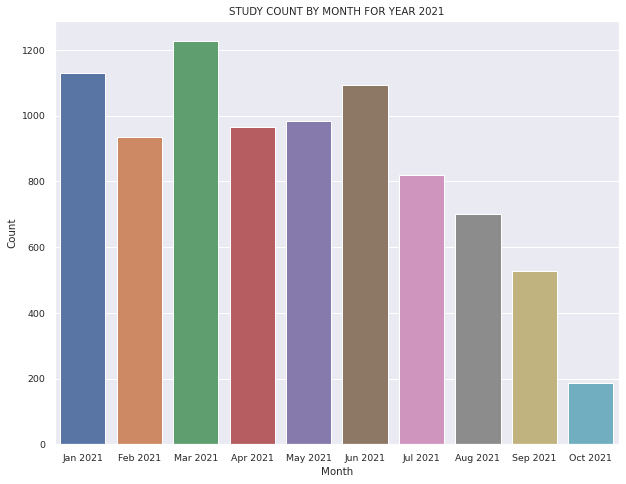

In [0]:
#VISUALIZATING USING SEABORN
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")
plt.figure(figsize=(8, 6))
sns.barplot(x="Month", y="count", data=studyplot_pd)

# set title and labels
plt.title("STUDY COUNT BY MONTH FOR YEAR 2021")
plt.xlabel("Month")
plt.ylabel("Count")

# show the plot
plt.show()

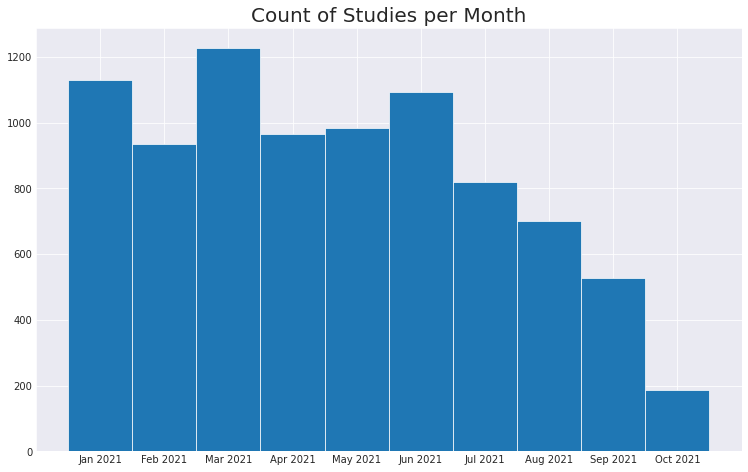

In [0]:
# USING '_mpl-gallery' PLOT
import matplotlib.pyplot as plt
plt.style.use('_mpl-gallery')

# plotting
fig, ax = plt.subplots(figsize=(10, 6)) # specify the plot size
ax.bar(studyplot_pd['Month'], studyplot_pd['count'], width=1, edgecolor="white", linewidth=0.7)
ax.set_title("Count of Studies per Month", fontsize=20)
plt.show()


Out[48]: Text(0.5, 1.0, 'STUDY COUNT BY MONTH FOR YEAR 2021')

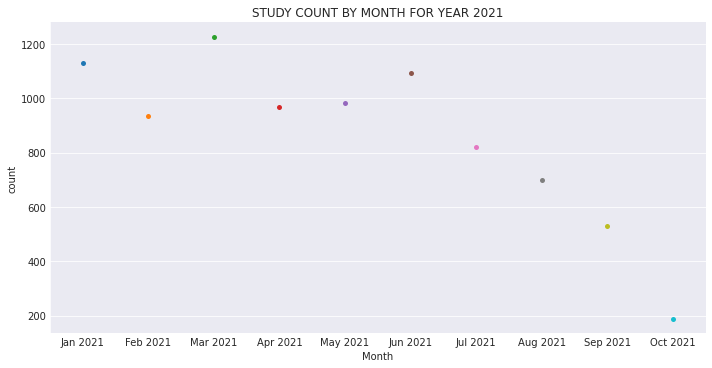

In [0]:
import seaborn as sns

sns.set_style("darkgrid")
sns.catplot(data=studyplot_pd, kind="swarm", x="Month", y="count", height=5, aspect=2)
plt.title("STUDY COUNT BY MONTH FOR YEAR 2021")

Out[49]: (0.5, 10.5)

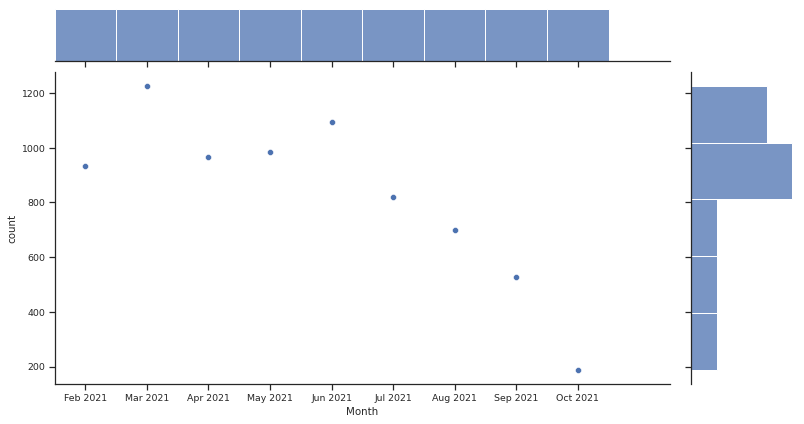

In [0]:
import seaborn as sns

sns.set(style="ticks", color_codes=True)
sns.set_context("notebook", font_scale=0.85, rc={"lines.linewidth": 2.5})

#plotting
g = sns.jointplot(data=studyplot_pd, x="Month", y="count", height=6)
g.fig.set_figwidth(12)
g.ax_joint.set_xlim(0.5, 10.5)
